In [1]:
import os
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle

import openpyxl

In [2]:
output_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output')
risk_path = os.path.join(output_path,'risk')
figure_path = os.path.join('C:\\','projects','pg_risk_analysis_output','output','figures')

# Read and restructure results

In [3]:
def restructure_output(hazard_type,infra_type):
    """
    Read the risk results of historical (FL) and present (TC) climate model
    """
    outputs = {}
    for risk_output in os.listdir(risk_path):
        climate_model = os.path.splitext(risk_output)[0].split('_')[3]
        if (hazard_type in risk_output) & (infra_type in risk_output) & (climate_model in risk_output):
            check_sheets = pd.ExcelFile(os.path.join(risk_path,risk_output),engine='openpyxl').sheet_names
            for sheet in check_sheets:
                out = pd.read_excel(os.path.join(risk_path,risk_output),sheet_name= sheet, index_col=[0],engine='openpyxl')
                outputs[risk_output[:3],climate_model,sheet] = out
    df = pd.concat(outputs).unstack(level=2).dropna(axis=1, how='all')
    
    # country_codes does not include Singapore (no fl/tc risk), Mongolia
    if hazard_type == 'fl':
        country_codes = ['CHN','IDN','JPN','KOR','MMR','MYS','PHL','PRK','THA','TWN','VNM']
    elif hazard_type == 'tc':
        country_codes = ['BRN','CHN','IDN','JPN','KHM','KOR','LAO','MMR','MYS','PHL','PRK','THA','TWN','VNM']
        
    reframe_risk = {}
    model_risk = {}
    
    if hazard_type == 'fl':
        climate_model = 'historical'
    elif hazard_type == 'tc':
        climate_model = 'present'
        
    for country_code in country_codes:
        reframe_risk[country_code] = df.unstack(level=-1).T.unstack(level=-1)[country_code]

        model_risk[country_code] = reframe_risk[country_code][climate_model].reset_index()
        model_risk[country_code] = model_risk[country_code].rename(columns={'level_0':'curve_code', 'level_1':'asset_type'})
        model_risk[country_code]['country_code'] = country_code
        model_risk[country_code]['climate_model'] = climate_model
        model_risk[country_code]['infra_type'] = infra_type

        df_risk_result = pd.concat(model_risk.values(), keys=model_risk.keys())
        risk_result = pd.concat([df_risk_result])

        risk_result['asset_type'] = risk_result['asset_type'].replace({'line_risk':'line','plant_risk':'plant',
                                                                       'substation_risk': 'substation','tower_risk':'tower',
                                                                       'pole_risk': 'pole'})
        
        risk_result['country_code'] = risk_result['country_code'].replace({'BRN':'Brunei','CHN':'China','IDN':'Indonesia','JPN':'Japan',
                                                                           'LAO':'Laos','MYS':'Malaysia','MMR':'Myanmar',
                                                                           'PRK':'North Korea','PHL':'Philippines','KHM':'Cambodia',
                                                                           'SGP':'Singapore','KOR':'South Korea','TWN':'Taiwan',
                                                                           'THA':'Thailand','VNM':'Vietnam'})
        
        risk_result['infra_type'] = risk_result['infra_type'].replace({'osm':'Open\nStreet Map','gov':'Government\ndata'})
        columns_to_multiply = ['mean_risk', 'lower_risk', 'upper_risk']
        risk_result[columns_to_multiply] = risk_result[columns_to_multiply] * 1.142203

    return risk_result

In [4]:
df = restructure_output('tc','osm')

In [5]:
df.loc['CHN']# multiply

,curve_code,asset_type,mean_risk,lower_risk,upper_risk,country_code,climate_model,infra_type
0,W2_1_1,substation,3.421818e+07,2.566363e+07,4.277272e+07,China,present,Open\nStreet Map
1,W2_1_2,substation,2.113923e+07,1.585442e+07,2.642404e+07,China,present,Open\nStreet Map
2,W2_1_3,substation,1.140606e+07,8.554545e+06,1.425757e+07,China,present,Open\nStreet Map
3,W2_1_4,substation,7.185818e+06,5.389363e+06,8.982272e+06,China,present,Open\nStreet Map
4,W2_1_5,substation,6.045212e+06,4.533909e+06,7.556515e+06,China,present,Open\nStreet Map
...,...,...,...,...,...,...,...,...
205,W4_52,pole,1.653028e+07,1.239771e+07,2.066285e+07,China,present,Open\nStreet Map
206,W4_53,pole,1.438394e+07,1.078795e+07,1.797992e+07,China,present,Open\nStreet Map
207,W4_54,pole,1.406428e+07,1.054821e+07,1.758035e+07,China,present,Open\nStreet Map
208,W4_55,pole,1.458498e+07,1.093873e+07,1.823122e+07,China,present,Open\nStreet Map


# Create figure for TC OSM present risk

In [6]:
tc_osm_risk = restructure_output('tc','osm')
tc_gov_risk = restructure_output('tc','gov')
tc_risk = pd.concat([tc_osm_risk,tc_gov_risk], axis=0)

In [7]:
tc_risk.loc['CHN']

,curve_code,asset_type,mean_risk,lower_risk,upper_risk,country_code,climate_model,infra_type
0,W2_1_1,substation,3.421818e+07,2.566363e+07,4.277272e+07,China,present,Open\nStreet Map
1,W2_1_2,substation,2.113923e+07,1.585442e+07,2.642404e+07,China,present,Open\nStreet Map
2,W2_1_3,substation,1.140606e+07,8.554545e+06,1.425757e+07,China,present,Open\nStreet Map
3,W2_1_4,substation,7.185818e+06,5.389363e+06,8.982272e+06,China,present,Open\nStreet Map
4,W2_1_5,substation,6.045212e+06,4.533909e+06,7.556515e+06,China,present,Open\nStreet Map
...,...,...,...,...,...,...,...,...
121,W2_7_2,substation,NaN,NaN,NaN,China,present,Government\ndata
122,W2_7_3,substation,NaN,NaN,NaN,China,present,Government\ndata
123,W2_7_4,substation,NaN,NaN,NaN,China,present,Government\ndata
124,W2_7_5,substation,NaN,NaN,NaN,China,present,Government\ndata


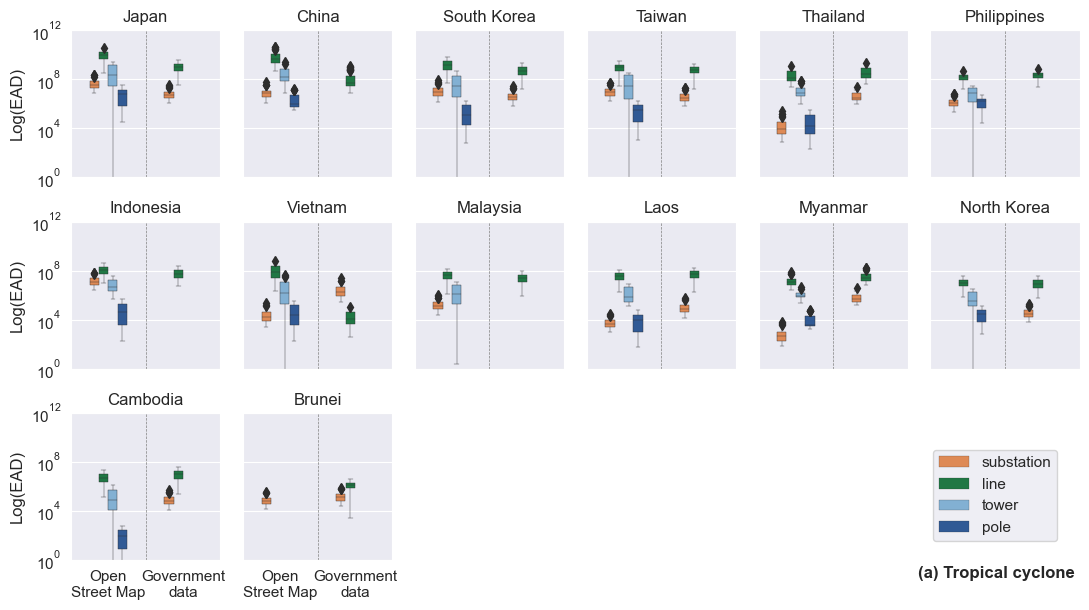

In [13]:
# sort from highest to lowest risk
country_codes = ['JPN','CHN','KOR','TWN','THA','PHL','IDN','VNM','MYS','LAO','MMR','PRK','KHM','BRN']

fig, axes = plt.subplots(3, 6, figsize=(11,6.2), sharex=True, sharey=False)

#my_pal1 = {"line": "#8CB369", "plant": "#F4E285", "substation": "#F4A259", "tower": "#5B8E7D", "pole": "#BC4B51"}
my_pal = {"plant": "#F8312E", "substation": "#F5843F", "tower": "#74B2E1", "pole": "#2157A5", "line": "#118642"}


for i, country_code in enumerate(country_codes):
    row = i // 6
    col = i % 6
    ax = axes[row][col]

    tc_country_risk = tc_risk.loc[country_code]
    
    #sns.set_style('darkgrid')

    sns.boxplot(data=tc_country_risk, x='infra_type', y='mean_risk', hue='asset_type',width=0.5,linewidth=0.3,
                palette=my_pal, ax=ax)

    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_title(tc_country_risk['country_code'].values[0], fontsize=12)
    ax.tick_params(labelsize=11)
    ax.set_ylim([1e0, 1e12])
    
    # Remove legends
    ax.get_legend().remove()
    
    # Set y-axis label for leftmost column
    if col == 0:
        ax.set_ylabel('Log(EAD)', fontsize=12)
        ax.yaxis.set_tick_params(labelleft=True)  #display the values of the y-axis coordinates of fist column
    else:
        ax.set_ylabel('')
        ax.yaxis.set_tick_params(labelleft=False)  #do not display the values of the y-axis coordinates of the other columns

    if row == 3:
        ax.tick_params(axis='x', which='both', bottom=True, length=2, width=0.2, color='black')

    # Add a vertical line in the middle of each subplot
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=0.5)
        
# Remove any remaining empty subplots
for j in range(len(country_codes), len(axes.flatten())):
    axes.flatten()[j].remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.3)

# Adjust the coordinates of legend as needed                                                                                            
legend_position = (5.5, 0.8)
plt.legend(bbox_to_anchor=legend_position,fontsize=11)

fig.text(0.91, 0.06, "(a) Tropical cyclone", fontsize=12, ha='center',fontweight='bold')

plt.savefig(os.path.join(figure_path,'Figure 4-a OSM & GOV.jpg'),dpi=450)

plt.show()


# Create figure for FL historical risk

In [9]:
fl_osm_risk = restructure_output('fl','osm')
fl_gov_risk = restructure_output('fl','gov')
fl_risk = pd.concat([fl_osm_risk,fl_gov_risk], axis=0)

In [10]:
fl_risk.loc['CHN']

,curve_code,asset_type,mean_risk,lower_risk,upper_risk,country_code,climate_model,infra_type
0,F5_1_1,line,3.181730e+06,2.386297e+06,3.977162e+06,China,historical,Open\nStreet Map
1,F5_1_2,line,3.499903e+06,2.624927e+06,4.374879e+06,China,historical,Open\nStreet Map
2,F5_1_3,line,4.136249e+06,3.102187e+06,5.170311e+06,China,historical,Open\nStreet Map
3,F5_1_4,line,5.186220e+06,3.889665e+06,6.482775e+06,China,historical,Open\nStreet Map
4,F5_1_5,line,5.704848e+06,4.278636e+06,7.131059e+06,China,historical,Open\nStreet Map
5,F5_1_6,line,6.742084e+06,5.056563e+06,8.427605e+06,China,historical,Open\nStreet Map
6,F5_1_7,line,2.131759e+06,1.598819e+06,2.664699e+06,China,historical,Open\nStreet Map
7,F5_1_8,line,2.344929e+06,1.758697e+06,2.931162e+06,China,historical,Open\nStreet Map
8,F5_1_9,line,2.771289e+06,2.078467e+06,3.464111e+06,China,historical,Open\nStreet Map
9,F5_1_10,line,3.474775e+06,2.606081e+06,4.343469e+06,China,historical,Open\nStreet Map


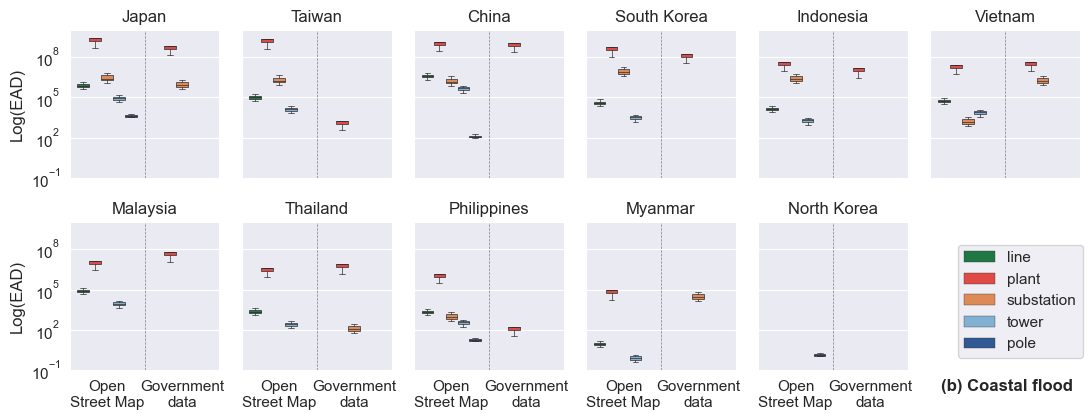

In [11]:
country_codes = ['JPN','TWN','CHN','KOR','IDN','VNM','MYS','THA','PHL','MMR','PRK']

fig, axes = plt.subplots(2, 6, figsize=(11,4.3), sharex=True, sharey=False)

#my_pal1 = {"line": "#8CB369", "plant": "#F4E285", "substation": "#F4A259", "tower": "#5B8E7D", "pole": "#BC4B51"}
my_pal = {"plant": "#F8312E", "substation": "#F5843F", "tower": "#74B2E1", "pole": "#2157A5", "line": "#118642"}

for i, country_code in enumerate(country_codes):
    row = i // 6
    col = i % 6
    ax = axes[row][col]

    fl_country_risk = fl_risk.loc[country_code]
    
    sns.set_style('darkgrid')

    sns.boxplot(data=fl_country_risk, x='infra_type', y='mean_risk', hue='asset_type',width=0.8,linewidth=0.5, palette=my_pal, ax=ax)

    ax.set_xlabel('')

    ax.set_yscale('log')
    ax.set_title(fl_country_risk['country_code'].values[0], fontsize=12)
    ax.tick_params(labelsize=11)
    ax.set_ylim([1e-1, 1e10])
    
    # Remove legends
    ax.get_legend().remove()

    # Set y-axis label for leftmost column
    if col == 0:
        ax.set_ylabel('Log(EAD)', fontsize=12)
        ax.yaxis.set_tick_params(labelleft=True)  #display the values of the y-axis coordinates of fist column

    else:
        ax.set_ylabel('')
        ax.yaxis.set_tick_params(labelleft=False)  #do not display the values of the y-axis coordinates of the other columns

    if row == 2:
        ax.tick_params(axis='x', which='both', bottom=True, length=2, width=0.2, color='black')

    # Add a vertical line in the middle of each subplot
    ax.axvline(x=0.5, color='gray', linestyle='--', linewidth=0.5)
        
# Remove any remaining empty subplots
for j in range(len(country_codes), len(axes.flatten())):
    axes.flatten()[j].remove()

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.3)

# Adjust the coordinates of legend as needed                                                                                            
legend_position = (2.22, 0.9)
plt.legend(bbox_to_anchor=legend_position,fontsize=11)

fig.text(0.92, 0.08, "(b) Coastal flood", fontsize=12, ha='center',fontweight='bold')

plt.savefig(os.path.join(figure_path,'Figure 4-b OSM & GOV.jpg'),dpi=450)

plt.show()


# Combine TC and Flood figures

In [14]:
from PIL import Image

image1 = Image.open(os.path.join(figure_path,'Figure 4-a OSM & GOV.jpg'))
image2 = Image.open(os.path.join(figure_path,'Figure 4-b OSM & GOV.jpg'))

if image1.width != image2.width:
    raise ValueError('Inconsistent Image Width')

# Create a new image with a width equal to the sum of the widths of the two images,
# and a height equal to the sum of the heights of the two images.
merged_image = Image.new('RGB', (image1.width, image1.height + image2.height))

merged_image.paste(image1, (0, 0))
merged_image.paste(image2, (0, image1.height))

merged_image.save(os.path.join(figure_path,"Figure 4-EAD combined.jpg"))